# The Power of Parallel Processing feat. multithreading and multiprocessing

If you've worked with data, chances are you've had to deal with large datasets. and I mean LARGE!

![Large Dataset](../img/large-dataset.jpeg)

[Source](https://medium.com/@laxmi.vanam17/large-data-sets-in-machine-learning-4ce3a7916e92)

When working with large datasets, one consequence is slower processing. To demonstrate, we are going to try to fetch some metadata about all the connections we have access to based on all the whitelabels we have access to without parallel processing.

First we'll get our API token by running `%env API_TOKEN` in one cell, then copy it and run `API_TOKEN = <pasted-token>` in another cell to set it as a variable. I've deleted the blocks so you can't see it (but you'll need to do these steps!)

Next, we'll see the list of whitelabels we have access to. For each whitelabel, we will then retrieve a list of connections and put it altogether to give us a master list. This is a part of `get_datasets('external')` though some filtering does happen.

In [3]:
import locussdk as locus
import pandas as pd

whitelabels = locus.get_whitelabel()
pd.DataFrame(whitelabels[0:10])

,whitelabelid,company
0,1,Atom
1,2,AdLoop
2,3,Advantex
3,4,WL TEST
4,5,Hydropool
5,6,Gourmet
6,7,CHR
7,8,FreeMedia
8,9,Metroland
9,10,Ocono


In [4]:
%%time
import requests

headers = {'eq-api-jwt': API_TOKEN}
route = 'https://api.locus.place/prod'

connections = []
for wl in whitelabels:
    params = {'whitelabel': wl['whitelabelid']}
    r = requests.get(f"{route}/connections", params=params, headers=headers)
    connections.extend(r.json())

CPU times: user 2.41 s, sys: 107 ms, total: 2.51 s
Wall time: 37.8 s


If you don't believe that it's there, run the next line!

In [5]:
pd.DataFrame(connections[0:5])

,id,set_id,set_name,columns,whitelabel,customer,type,name,created,updated,last_sync,is_syncing,records
0,1576,122,COVID Ontario,"{'Row_ID': {'hash': False, 'type': 'Number', '...",1,9324,google sheet,COVID Ontario,2021-01-21T19:48:09.099Z,2021-01-21T19:52:42.148Z,2021-01-21T19:52:42.153Z,False,197152
1,1570,120,test gs2,"{'col_1': {'hash': False, 'type': 'Number', 'd...",1,9324,google sheet,test gs2,2021-01-20T23:30:12.363Z,2021-01-20T23:30:32.727Z,2021-01-20T23:30:32.731Z,False,5
2,1585,123,test new branch,"{'col_1': {'hash': False, 'type': 'Number', 'd...",1,9324,google sheet,test new branch,2021-01-22T15:18:57.636Z,2021-01-22T15:19:17.292Z,2021-01-22T15:19:17.297Z,False,5
3,1573,121,test gs string,"{'col_1': {'hash': False, 'type': 'string', 'd...",1,9324,google sheet,test gs string,2021-01-21T15:30:02.203Z,2021-01-21T17:03:09.559Z,2021-01-21T17:03:09.564Z,False,5
4,1569,119,test gs,"{'col_1': {'hash': False, 'type': 'Number', 'd...",1,9324,google sheet,test gs,2021-01-20T23:23:57.193Z,2021-01-20T23:24:25.218Z,2021-01-20T23:24:25.221Z,False,5


To avoid spending lots of time waiting around, one way is to optimize the runtime of your code by using parallel processing. Parallel Processing is nothing new to us. Here's an example: Imagine you're an EQ data analyst and you find out there are 3 reports waiting to be done for a specific client. You can either do all 3 reports yourself one by one, or get 2 other data analysts to help you out perhaps by taking one part in each report or doing one report each. Parallel processing is the second option.

![single vs parallel.png](../img/single-vs-parallel.png)

Python offers this capability of parallel processing in 2 ways, through 2 modules: multiprocessing and threading! You'll see this example again later in multithreading.

# What is multiprocessing?

Python was designed this in mind: computers would only have one core. One process to be run by the one core at a time. Process is an executable program (so running some code) with its own memory space. But nowadays, that's not the case- computers have multiple cores. Since Python was not designed to have multiple processes run at the same time so there was potential of memory getting mixed up between the processes. It's like suddenly being able to read someone else's thoughts all of a sudden which can get chaotic. So Python has a Global Interpreter Lock (GIL) in place to help manage memory management and run one process with one core at a time. But this means Python doesn't effectively use all of the cores that are at its disposal. That's where multiprocessing comes in: create multiple processes with its own memory space for each core.
![Multiprocessing](../img/multiprocessing.png)
[Source](https://levelup.gitconnected.com/multi-threading-and-multiprocessing-in-python-3d5662f4a528)

Multiprocessing bypasses GIL and uses all cores (one process per core). You'll see the speed difference in a bit through an example with pandas and Modin. An analogy of this would be 3 data analysts working on 1 report as opposed to 1 data analyst working on 3 reports.

# When would you use multiprocessing?

This method is great for CPU-intensive processes like deep analyses, heavy filtering and data manipulation. By having multiple processes, you lighten the load instead of one process doing all of the work, like in the data analyst scenario.

# Mulitprocessing in Python for Data Analysis
## Introduction to Pandas Data Frames
Pandas is a highly optimzed library written in C or Cython that provides data structures along with the neccessary tools to load and operate on them. It includes two principal data structures, `series` and `dataframes`. The dataframe is two-dimensional, size-mutable, potentially heterogeneous tabular data which resembles a standard spreadsheet. 

Python with pandas is in use in a wide variety of academic and commercial domains, including Finance, Neuroscience, Economics, Statistics, Advertising, Web Analytics, and more because it supports the following features and more: 

- A fast and efficient DataFrame object for data manipulation with integrated indexing

- Tools for reading and writing data between in-memory data structures and different formats: CSV and text files, Microsoft Excel, SQL databases, and the fast HDF5 format

- Flexible reshaping and pivoting of data sets

- Columns can be inserted and deleted from data structures for size mutability

- Aggregating or transforming data with a powerful group by engine allowing split-apply-combine operations on data sets;

- High performance merging and joining of data sets;

- Hierarchical axis indexing provides an intuitive way of working with high-dimensional data in a lower-dimensional data structure;    

# If Pandas is so great why do we need anything else? 
The popularity of Pandas is largely due to it's maturity and time in use but, it was written to use a single processor and loads the entire dataframe into memory thus, severely lowering it's scalability and efficiency. In the last few years the open source community has developed modules built on top of Pandas like Dask, Ray, and Modin which run python code across compute clusters or parallelize code to run on several clusters. RAPIDs for example, is a partial Pandas replacement that runs code on GPUs. 

![ModinVDataframe](../img/mostcommonpandas.png)

## Introduction to Modin

Modin was designed for terrabyte sized data sets by splitting the dataframe into smaller more manageble units allowing it to be loaded into separate processors and memory thus, parallelizing your Python code. 

It covers 90% of the Pandas API with a focus on the most commonly used Pandas methods. Modin is a superset of Pandas which means the remaining falls back to native Pandas. 

![ModinVDataframe](../img/PandasVModin1.png)

## Using Modin

Modin includes a scheduler that abstracts the hardware from the interpreter so that you don't need to manage it within your code.

You can learn more about how to install and use it at https://github.com/modin-project/modin.

![Modinarchitecture](../img/modin_architecture.png)

Run the next few cells to see the runtime when using pandas. Once you're done, re-run these cells using Modin!

In [6]:
import locussdk as locus
import pandas as pd
# import modin.pandas as pd

In [7]:
report = 2163
locus.get_aoi_frequencies(report)

[{'date_range_type': 'week',
  'date_range': {'date_type': 2,
   'start_date': '2020-01-01T00:00:00.000Z',
   'end_date': '2020-01-05T00:00:00.000Z'}},
 {'date_range_type': 'week',
  'date_range': {'date_type': 2,
   'start_date': '2020-01-06T00:00:00.000Z',
   'end_date': '2020-01-12T00:00:00.000Z'}},
 {'date_range_type': 'week',
  'date_range': {'date_type': 2,
   'start_date': '2020-01-13T00:00:00.000Z',
   'end_date': '2020-01-19T00:00:00.000Z'}},
 {'date_range_type': 'week',
  'date_range': {'date_type': 2,
   'start_date': '2020-01-20T00:00:00.000Z',
   'end_date': '2020-01-26T00:00:00.000Z'}},
 {'date_range_type': 'week',
  'date_range': {'date_type': 2,
   'start_date': '2020-01-27T00:00:00.000Z',
   'end_date': '2020-01-31T00:00:00.000Z'}},
 {'date_range_type': 'month',
  'date_range': {'date_type': 3,
   'start_date': '2020-01-01T00:00:00.000Z',
   'end_date': '2020-01-31T00:00:00.000Z'}}]

In [8]:
date_range = locus.get_aoi_frequencies(report)[5]['date_range']

In [9]:
%%time
df = locus.get_dataset('eq', report, enhancement = 'aoi', date_range=date_range, resolution='postalcode' )

CPU times: user 571 ms, sys: 44.1 ms, total: 615 ms
Wall time: 657 ms


In [10]:
%%time
df.head()
print(len(df['geo_id'].unique())) 
print(len(df['poi_id'].unique()))

12514
51
CPU times: user 7.33 ms, sys: 0 ns, total: 7.33 ms
Wall time: 6.17 ms


In [11]:
%%time
visit_per_pc = df.groupby('geo_id').sum()['visits']

CPU times: user 22.2 ms, sys: 144 µs, total: 22.4 ms
Wall time: 21.4 ms


In [12]:
%%time
df_top = pd.DataFrame(visit_per_pc[visit_per_pc.gt(visit_per_pc.quantile(0.995))]).sort_values('visits',ascending=False).reset_index()
len(df_top)

CPU times: user 9.46 ms, sys: 99 µs, total: 9.56 ms
Wall time: 8.01 ms


63

In [13]:
%%time
top_geojson = locus.get_geojson_pc(list(df_top['geo_id']))

CPU times: user 117 ms, sys: 11.4 ms, total: 129 ms
Wall time: 11.5 s


In [14]:
%%time
df_demo = pd.DataFrame(visit_per_pc[visit_per_pc>100]).sort_values('visits',ascending=False).reset_index()
df_demo

CPU times: user 4.33 ms, sys: 21 µs, total: 4.35 ms
Wall time: 3.21 ms


,geo_id,visits
0,L0K1S0,562
1,L0S1N0,525
2,L4B4H6,475
3,L0S1J0,473
4,L0G1M0,471
...,...,...
342,L0L2L0,101
343,M1B3S3,101
344,L4B3P9,101
345,L6A1E9,101


In [15]:
# locus.list_enrichment('demographic')

In [16]:
# %%time
# df_enrich_income = locus.enrich(df_demo, 'demographic', 'Household Income')

In [17]:
# %%time
# df_enrich_income

In [18]:
# %%time
# df_enrich_education = locus.enrich(df_demo, 'demographic', 'Education Breakdown')

In [19]:
# %%time
# df_enrich_education

In [20]:
# %%time
# pd.DataFrame(df_enrich_education.drop('visits',axis=1).mean().reset_index())

In [21]:
# %%time
# df_enrich_age = locus.enrich(df_demo, 'demographic', 'Resident Age Breakdown')

In [22]:
# %%time
# df_enrich_age

Now go back to the first cell below the Modin image and comment out `import pandas as pd`. Comment back in `import modin.pandas as pd` and see how much faster it runs! You should see a drop in runtime like this:

### Pandas
![pandas geojson method 11.5s](../img/run-pandas.png)

### Modin.pandas
![pandas geojson method 1.5s](../img/run-modin.png)
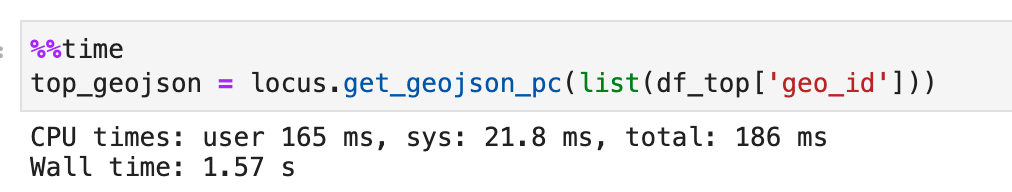
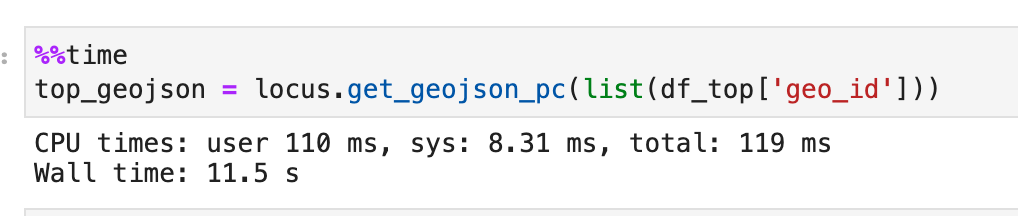

# You mentioned threading, what is multithreading?

If the tasks aren't CPU-intensive such as data fetching and other I/O operations like web scraping or reading files, we can leverage threading. Threads are components of a process that work in parallel and share the same memory space. As mentioned earlier, a process is executable code with its own memory space. When data fetching, one process is enough (instead of multiple processes) since the processor will be waiting around for data to come back so we can fetch data in parallel by using threads. Python will execute one thread at a time utilizing the one process.

An example is: think about multiple people editing a google document in real-time. The google document is one memory space and multiple people are adding text to this document. Think of each person as a thread. In our data analyst example, it's like 3 analysts working on one report to speed up the process. In multiprocessing, it'd be like multiple google documents being edited by 1 person each or in our data analyst example, 1 data analyst doing 1 report each.

### Multithreading
![Multithreading](../img/multithreading-analogy.png)

### Multiprocessing
![Multiprocessing](../img/multiprocessing-analogy.png)

# So when would we use threading?

1. Creating processes can be a bit slow so if the code that you are running is not CPU-intensive such as data fetching, threading is a great option. Creating threads is much more lightweight than creating processes. 
2. Sharing objects is easier between threads since they share the same memory space so if you're fetching from many different areas and combining the data, threading is good.
![Multithreading diagram](../img/threading-diagram.jpeg)
[Source](https://timber.io/blog/multiprocessing-vs-multithreading-in-python-what-you-need-to-know/)

# When should we not use threading?

1. There is overhead associated with managing threads
2. Increases the complexity of the program, which can make debugging more difficult

# An example of multithreading using ThreadPoolExecutor

We use multithreading quite a bit in locussdk as well as the backend providing the data into locussdk for LOCUS Notebook. 

`ThreadPoolExecutor` from the in-built library, `concurrent.futures` is one way to use multithreading. What it does is it creates threads and groups them altogether in one pool of memory. Based on the number of threads, each thread simultaneously takes on a task. Once it's done, if there is information sent back, the information is stored in `as_completed`. One example is getting a list of all external datasets a.k.a the connections made in Connection Hub in locussdk.

Let's first create a helper function for fetching connections for a single whitelabel.

In [23]:
route = 'https://api.locus.place/prod'
def get_connections_per_whitelabel(wl):
    params = {'whitelabel': wl['whitelabelid']}
    r = requests.get(f"{route}/connections", params=params, headers=headers)
    return r.json()

Now we'll use ThreadPoolExecutor to do the same thing that we did in the beginning with the for loop, except there's a few things to note:
- we need to create a variable for collecting all of the tasks a.k.a the queue called `conn_tasks`'
- we need to specify how many threads can be created based on the workload provided (the queue)
- `executor.submit` will execute our helper function which is provided as the first argument. The rest of the arguments are for our helper function (which requires one). So if our helper function required 2 arguments, `executor.submit` would have 3 arguments, not 2.
- as_completed will contain all of the results from each thread that's done their task from the queue (which we provide as an argument)

In [24]:
%%time

from concurrent.futures import ThreadPoolExecutor, as_completed

import requests

headers = {'eq-api-jwt': API_TOKEN}
threads = 8
connections_pp = []
conn_tasks = []

with ThreadPoolExecutor(max_workers=threads) as executor:
    for wl in whitelabels:
        conn_tasks.append(executor.submit(get_connections_per_whitelabel, wl))
    
    for future in as_completed(conn_tasks):
        connections_pp.extend(future.result())

CPU times: user 2.47 s, sys: 171 ms, total: 2.64 s
Wall time: 5.92 s


Wow, that was fast! If you don't believe it's the same result from the beginning, run the next cell.

In [25]:
pd.DataFrame(connections_pp[0:5])

,id,set_id,set_name,columns,whitelabel,customer,type,name,created,updated,last_sync,is_syncing,records
0,1576,122,COVID Ontario,"{'Row_ID': {'hash': False, 'type': 'Number', '...",1,9324,google sheet,COVID Ontario,2021-01-21T19:48:09.099Z,2021-01-21T19:52:42.148Z,2021-01-21T19:52:42.153Z,False,197152
1,1570,120,test gs2,"{'col_1': {'hash': False, 'type': 'Number', 'd...",1,9324,google sheet,test gs2,2021-01-20T23:30:12.363Z,2021-01-20T23:30:32.727Z,2021-01-20T23:30:32.731Z,False,5
2,1585,123,test new branch,"{'col_1': {'hash': False, 'type': 'Number', 'd...",1,9324,google sheet,test new branch,2021-01-22T15:18:57.636Z,2021-01-22T15:19:17.292Z,2021-01-22T15:19:17.297Z,False,5
3,1573,121,test gs string,"{'col_1': {'hash': False, 'type': 'string', 'd...",1,9324,google sheet,test gs string,2021-01-21T15:30:02.203Z,2021-01-21T17:03:09.559Z,2021-01-21T17:03:09.564Z,False,5
4,1569,119,test gs,"{'col_1': {'hash': False, 'type': 'Number', 'd...",1,9324,google sheet,test gs,2021-01-20T23:23:57.193Z,2021-01-20T23:24:25.218Z,2021-01-20T23:24:25.221Z,False,5


### Summary

Parallel processing is powerful when dealing with large datasets whether it's coming from APIs or internally as it can significantly speed up the processing of them. Multiprocessing is useful when running complex logic or loading a large dataset whereas multithreading shines when data fetching from an API. It may not always be necessary to utilize parallel processing but when the going gets tough, the tough get going... to doing things in parallel!

# Sources

- [https://blog.floydhub.com/multiprocessing-vs-threading-in-python-what-every-data-scientist-needs-to-know/](https://blog.floydhub.com/multiprocessing-vs-threading-in-python-what-every-data-scientist-needs-to-know/)
- [https://timber.io/blog/multiprocessing-vs-multithreading-in-python-what-you-need-to-know/](https://timber.io/blog/multiprocessing-vs-multithreading-in-python-what-you-need-to-know/)
- [https://www.educative.io/edpresso/what-is-multithreading-in-python](https://www.educative.io/edpresso/what-is-multithreading-in-python)
- [Modin official repository](https://github.com/modin-project/modin)